In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib import cm
from matplotlib.patches import Circle
from astropy import units as u
from astropy import constants as const
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import time
start_total = time.time()
from plasma_jet_class import sieplasmajet
import warnings
warnings.filterwarnings('ignore')
import contextlib
import io
import sys

%matplotlib notebook

In [2]:
zl = 0.2; zs = 1.2

Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

print('Dl: ',Dl); print('Ds: ',Ds); print('Dls: ',Dls)
print('G: ',(const.G).value ,(const.G).unit)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
print('rho_crit :',rho_crit)
c_light = (const.c).to(u.cm/u.second)
print('c_light :', c_light)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
print('r0:', r0)
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E_g: ',theta_E_SIS() ,'arcsec')

theta_E_g = theta_E_SIS()
elipt = eta = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

Dl:  705.4019455128785 Mpc
Ds:  1760.3796178766652 Mpc
Dls:  1375.6149203241862 Mpc
G:  6.6743e-11 m3 / (kg s2)
rho_crit : 1.0483397591328813e-26 kg / m3
c_light : 29979245800.0 cm / s
r0: 10.0 kpc
scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E_g:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [3]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [4]:
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736

phi = np.linspace(0,2*np.pi, 3000)

In [5]:
eta = 0.3
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
psi0_plasma

<Quantity 0.47012438>

<IPython.core.display.Javascript object>


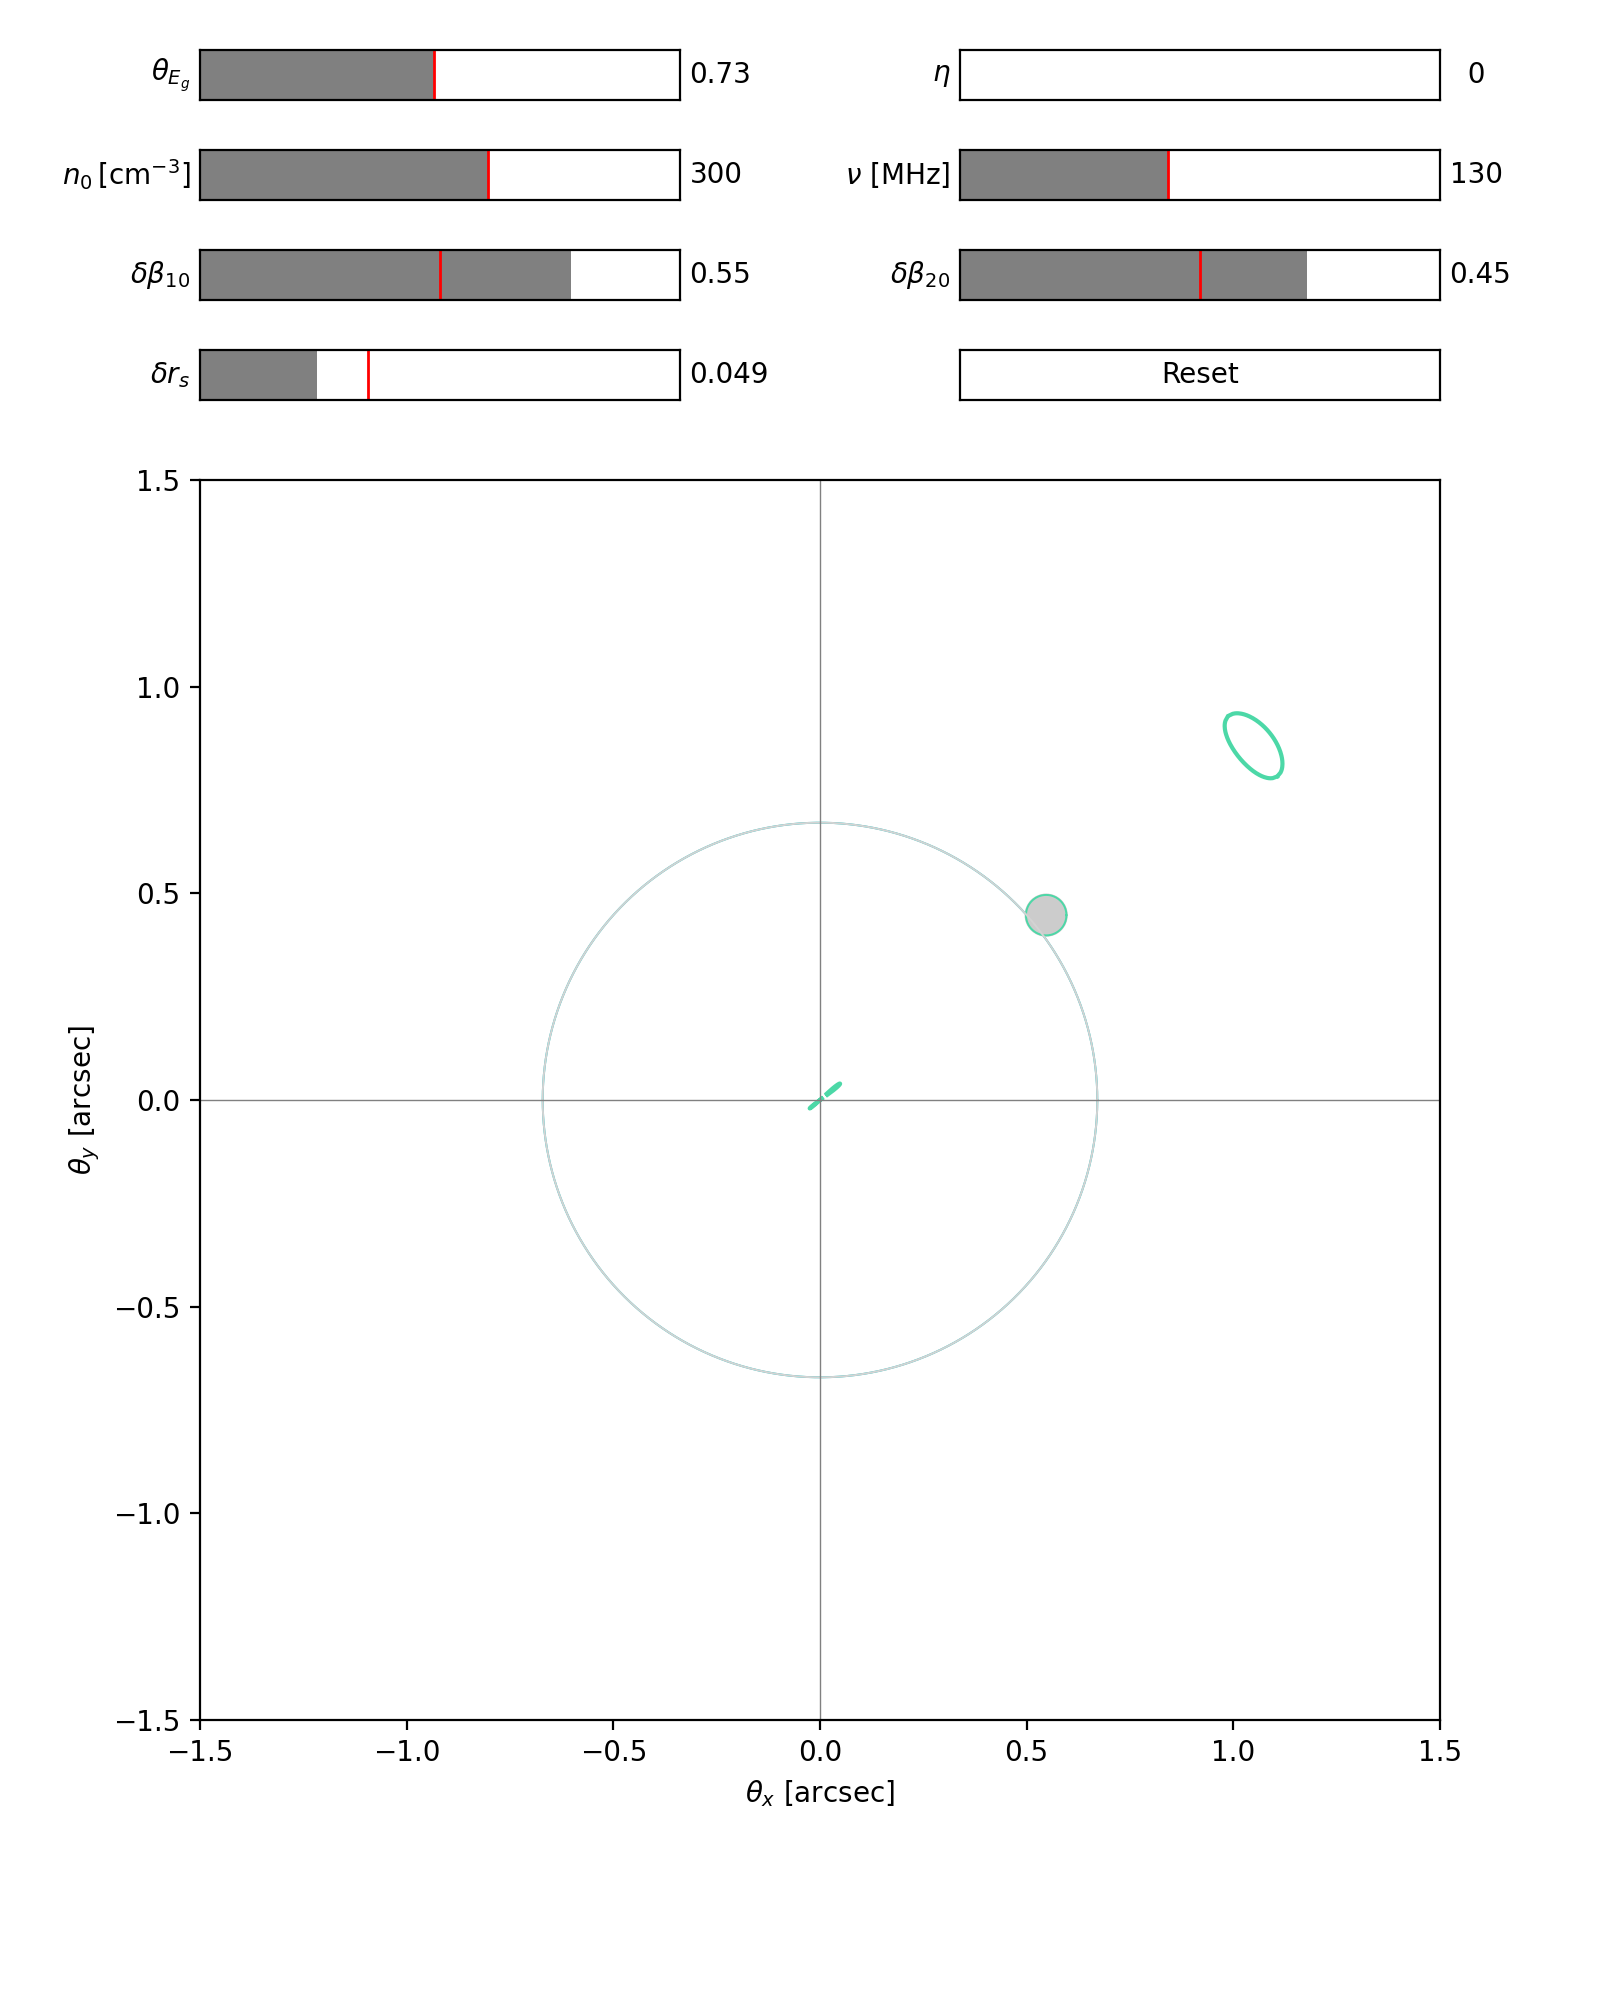

In [6]:
eta = 0.3
nu = 130.0 * u.MHz
omega = nu*(1.+zl)*2*np.pi
n0 = 300./(u.cm)**(3)

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value
theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

deltab_10 = 0
deltab_20 = 0
delta_rs = .07

sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)

fig = plt.figure(figsize=(8, 10),num="LENSTOMI")
ax = fig.add_subplot(111)
fig.subplots_adjust(bottom=0.1, top=0.8)

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])

plt.gca().set_aspect('equal', adjustable='box')

ax_theta_E_g = fig.add_axes([0.125, 0.95, 0.3, 0.025])
ax_eta = fig.add_axes([0.6, 0.95, 0.3, 0.025])
ax_n0 = fig.add_axes([0.125, 0.9, 0.3, 0.025])
ax_nu = fig.add_axes([0.6, 0.9, 0.3, 0.025])
ax_db10 = fig.add_axes([0.125, 0.85, 0.3, 0.025])
ax_db20 = fig.add_axes([0.6, 0.85, 0.3, 0.025])
ax_drs = fig.add_axes([0.125, 0.8, 0.3, 0.025])
resetax = plt.axes([0.6, 0.8, 0.3, 0.025])

button = Button(resetax, 'Reset', color='white', hovercolor='0.975')
s_theta_E_g = Slider(ax=ax_theta_E_g, label=r'$\theta_{E_{g}}$', valmin=0, valmax=1.5,valinit = 0.73,
              valfmt='%1.2g', facecolor='grey')
s_eta = Slider(ax=ax_eta,label= r'$\eta$', valmin=0, valmax=0.3, 
             valinit=0.3, valfmt='%3.2g', facecolor='grey')
s_n0 = Slider(ax=ax_n0,label= '$n_0 \, [\mathrm{cm}^{-3}] $', valmin=0, valmax=500, 
             valinit=300, valfmt='%i', facecolor='grey')
s_nu = Slider(ax=ax_nu,label= r'$\nu$ [MHz]', valmin=0, valmax=300, 
             valinit=130, valfmt='%i', facecolor='grey')
s_drs = Slider(ax=ax_drs,label= '$\delta r_{s}$', valmin=0, valmax=0.2, 
             valinit=0.07, valfmt='%1.2g', facecolor='grey')
s_db10 = Slider(ax=ax_db10,label= r'$\delta\beta_{10}$', valmin=-1, valmax=1, 
             valinit=0, valfmt='%1.2g', facecolor='grey')
s_db20 = Slider(ax=ax_db20,label= r'$\delta\beta_{20}$', valmin=-1, valmax=1, 
             valinit=0, valfmt='%1.2g', facecolor='grey')

theta_E = sie_plasma.theta_E

radii_1 = theta_E + sie_plasma.delta_r_1
radii_2 = theta_E + sie_plasma.delta_r_2

# critic_e = sie_plasma.critic()
critic = theta_E + sie_plasma.delta_r_criticline 
caustic_1 = sie_plasma.caustic_1
caustic_2 = sie_plasma.caustic_2

plot1, = ax.plot(radii_1*np.cos(phi),radii_1*np.sin(phi),zorder = 2 , color = '#4cd8a7')
plot2, = ax.plot(radii_2*np.cos(phi),radii_2*np.sin(phi),zorder = 2 , color = '#4cd8a7')
plot3, = ax.plot(theta_E*np.cos(phi),theta_E*np.sin(phi),zorder = 1, color = '#19bfbf', lw = .7)
plot4, = ax.plot(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20,zorder = 2, color = '#4cd8a7', lw = .7)
circ1 = Circle((deltab_10, deltab_20), delta_rs, zorder = 1, color = '#cccccc')
ax.add_artist(circ1)
plot6, = ax.plot(critic*np.cos(phi), critic*np.sin(phi),zorder = 2 , color = '#d3d3d3', lw = .7)
# plot7, = ax.plot(critic_e*np.cos(phi), critic_e*np.sin(phi),zorder = 2 , color = 'blue')
plot8, = ax.plot(caustic_1, caustic_2, zorder = 2 , color = 'red', lw = .7)


ax.set_xlabel(r'$\theta_{x}$ [arcsec]')
ax.set_ylabel(r'$\theta_{y}$ [arcsec]')
ax.axhline(0, linestyle='-',lw =0.5 ,color='grey') # horizontal lines
ax.axvline(0, linestyle='-',lw =0.5, color='grey') # vertical lines

def update(val):
    
    print('inside func') #a esto no me lo printea. Si hay error dentro de esta funcion, 
                        #no va a saltar, pero va a hacer que no se actualizen los plots
    
    theta_E_g = s_theta_E_g.val
    eta = s_eta.val  
    n0 = (s_n0.val)/(u.cm)**(3)
    nu = (s_nu.val)*u.MHz
    delta_rs = s_drs.val
    deltab_10 = s_db10.val
    deltab_20 = s_db20.val

    omega = nu*(1.+zl)*2*np.pi
    psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()
    
    psi0_plasma_num = psi0_plasma.value
    
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    
    theta_E = sie_plasma.theta_E
    
    radii_1 = theta_E + sie_plasma.delta_r_1
    radii_2 = theta_E + sie_plasma.delta_r_2
    
#     critic_e = sie_plasma.critic()
    critic = theta_E + sie_plasma.delta_r_criticline
    
    caustic_1 = sie_plasma.caustic_1
    caustic_2 = sie_plasma.caustic_2
    
    plot1.set_data(radii_1*np.cos(phi),radii_1*np.sin(phi))
    plot2.set_data(radii_2*np.cos(phi),radii_2*np.sin(phi))
    plot3.set_data(theta_E*np.cos(phi),theta_E*np.sin(phi))
    plot4.set_data(delta_rs*np.cos(phi) + deltab_10, delta_rs*np.sin(phi) + deltab_20)
    circ1.center = (deltab_10 , deltab_20)
    circ1.radius = delta_rs
    fig.canvas.draw_idle()
    plot6.set_data(critic*np.cos(phi), critic*np.sin(phi))
#     plot7.set_data(critic_e*np.cos(phi), critic_e*np.sin(phi))
    plot8.set_data(caustic_1, caustic_2)
    
def reset(event):
    s_theta_E_g.reset()
    s_eta.reset()
    s_n0.reset()
    s_nu.reset()
    s_drs.reset()
    s_db10.reset()
    s_db20.reset()

# nostdout() is a method for hiding the output (which in our plot is useless)
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout
    
with nostdout():
    s_theta_E_g.on_changed(update)
    s_eta.on_changed(update)
    s_n0.on_changed(update) 
    s_nu.on_changed(update)
    s_drs.on_changed(update)
    s_db10.on_changed(update)
    s_db20.on_changed(update)
    button.on_clicked(reset)